用于处理输出结果

In [ ]:
"""
System Environment
OS: Windows 10 家庭中文版
CPU: intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz 2.80GHz
GPU: GeForce GTX 1050
CUDA 9.1.84
Memory: 16 GiB

Python Environment
python 3.7.4 (anaconda)
numpy 1.16.5 
pandas 0.25.1
pytorch 1.1.0
scikit-learn 0.21.3
scipy 1.3.1
matplotlib 3.1.1
"""

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

In [2]:
from utils import SVC,PUK_kernel,numout2boolout,make_pipeline,test,y,Y,precision_score,recall_score

SVC的结果分析

In [ ]:
X_masked=np.load("./processedData/X/X_masked.npy")
x_masked=np.load("./processedData/X/x_masked.npy")

将多维标签的数据放入pandas Series里

In [ ]:
serieLabel = [[], [], [], []]
data=np.array([])
Cspace=np.logspace(-10, 10, num=20)
for kernel in ["PUK","sigmoid","rbf"]:
        SVC_data=np.load("./out/SVC_{}.npy".format(kernel))
        data=np.concatenate((data,SVC_data))
        for j, C in enumerate(Cspace):
                if kernel=='PUK':
                        serieLabel[0] += [kernel]*6
                        serieLabel[1] += ["numY"]*3+["boolY"]*3
                        serieLabel[2] += ["rec", "prec", "acc"]*2
                        serieLabel[3] += [C]*6
                else:
                        serieLabel[0] += [kernel]*3
                        serieLabel[1] += ["numY"]*3
                        serieLabel[2] += ["rec", "prec", "acc"]
                        serieLabel[3] += [C]*3

series = pd.Series(data=data, index=serieLabel)

pearson VII 核的性能

In [ ]:
# 作图展示一个模型的分数
def plotScore(kernel,boolY=False):
    Y="boolY" if boolY else "numY"
    plt.plot(np.log10(Cspace),series[kernel,Y,"rec"],label="recall")
    plt.plot(np.log10(Cspace),series[kernel,Y,"prec"],label="precision")
    plt.plot(np.log10(Cspace),series[kernel,Y,"acc"]+0.01,label="accuracy")

    plt.legend()
    plt.xlabel("lg C")
    plt.ylabel("score")
    plt.title("score of {} with {}".format(kernel,Y))
    plt.show()


In [ ]:
plotScore("PUK",True)
plotScore("PUK",False)

sigmoid核的性能

In [ ]:
plotScore("sigmoid")

rbf核的性能

In [ ]:
plotScore("rbf")

用最佳参数在测试集上测试

In [ ]:
test(X_masked,Y,x_masked,y,SVC,{"C":10,"kernel":PUK_kernel,"class_weight":"balanced"})

使用rbf核对bool化的y进行拟合

In [ ]:
test(X_masked,Y,x_masked,y,SVC,{"C":10,"kernel":"rbf","class_weight":"balanced"})

作出学习曲线

In [3]:
score=np.load("./out/lc_score.npy")

Text(0.5, 1.0, '')

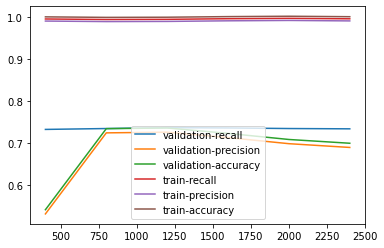

In [13]:
plt.plot(list(range(400,2800,400)),score[0][0],label="validation-recall")
plt.plot(list(range(400,2800,400)),score[0][1]-0.005,label="validation-precision")
plt.plot(list(range(400,2800,400)),score[0][1]+0.005,label="validation-accuracy")

plt.plot(list(range(400,2800,400)),score[1][0],label="train-recall")
plt.plot(list(range(400,2800,400)),score[1][1]-0.005,label="train-precision")
plt.plot(list(range(400,2800,400)),score[1][1]+0.005,label="train-accuracy")
plt.legend()
plt.title("learning curve")
plt.xlabel("train data")
plt.ylabel("score")

线性回归的结果分析

In [ ]:
for model in ["Lasso","Ridge","Logistic"]:
    prec=[]
    acc=[]
    recall=[]
    with open("./out/{}.out".format(model)) as f:
        for alpha in np.logspace(-5,5):
            f.readline()
            prec_cur=0
            acc_cur=0
            recall_cur=0
            for i in range(3):
                recall_cur+=float(f.readline().split('=')[-1])
                prec_cur+=float(f.readline().split('=')[-1])
                acc_cur+=float(f.readline().split('=')[-1])
                f.readline()
                f.readline()
                f.readline()
            recall.append(recall_cur/3)
            acc.append(acc_cur/3)
            prec.append(prec_cur/3)
    plt.plot(np.log10(np.logspace(-5,5)),acc,label="accuracy-{}".format(model))
    plt.plot(np.log10(np.logspace(-5,5)),prec,label="precision-{}".format(model))
    plt.plot(np.log10(np.logspace(-5,5)),recall,label="recall-{}".format(model))

plt.legend()
plt.xlabel("lg C")
plt.ylabel("score")
plt.title("score")

求岭回归在测试集上的性能

In [ ]:
pred,ppred=test(X_masked,Y,x_masked,y,Lasso,{"alpha":0.001})

In [ ]:
plt.hist(pred,bins=40)
plt.xlabel("prediction")
plt.ylabel("number")
plt.title("distribution of prediction")

In [ ]:
plt.plot(np.linspace(2.25,3,num=1000),[precision_score(numout2boolout(y),pred>threshold) for threshold in np.linspace(2.25,3,num=1000)],label="test")
plt.plot(np.linspace(2.25,3,num=1000),[precision_score(numout2boolout(Y),ppred>threshold) for threshold in np.linspace(2.25,3,num=1000)],label="validation")
plt.xlabel("threshold")
plt.ylabel("precision")
plt.legend()
plt.title("precision vs threshold")